# Ensemble Learning and Random Forests

Random Forests are an example of ensemble learning, training many trees and then aggregating the results into a prediction. Random Forests can be further combined with other models.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Most popular ensemble methods: 
- bagging
- boosting
- stacking

# Voting Classifiers

Generally achive better results than any of the individual methods. Law of large numbers.

![](images/vote1.png)
![](images/vote2.png)

## Create and train voting classifier

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [4]:
log_clf = LogisticRegression(solver='lbfgs', random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42) 

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], 
    voting='hard'
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

Measure accuracy - Voting classifier outperforms

In [5]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf): 
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


If all classifiers output probabilities (predict_proba), then you can use _soft voting_ to predict the highest class probability averaged over indidual classifiers. This can achieve higher performance because it gives more weight to highly confident votes.

>[!attention] to use soft voting with SVC, set `probability=True`. This slows down the training.

In [6]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [7]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf): 
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


# Bagging and Pasting

Use random subsets of the training set with the same algorithm for every predictor. The predictions are then aggregated. The aggregation reduces bias and variance (each individual predictor has a higher bias).

- Bagging
  - with replacement
  - more diversity
  - slightly higer bias
  - predictors less correlated so reduced variance
- Pasting: without replacement

In [8]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500, 
    max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [9]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [10]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [11]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

Saving figure decision_tree_without_and_with_bagging_plot


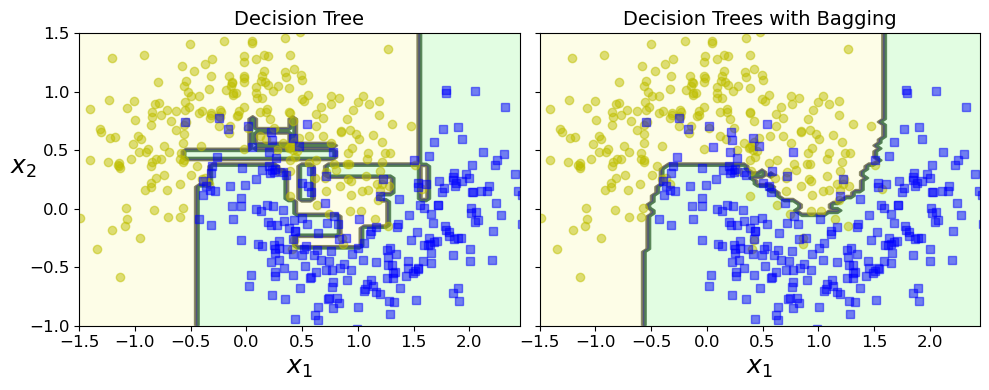

In [12]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

## Out-of-Bag Evaluation

When using bootstrapping, only about 63% of instances are trained per predictor. The rest are called _out-of-bag_ and can be used for validation._

Must set `oob_score=True` in the `BaggingClassifier`

In [13]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500, 
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

In [14]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

The decision function variable contains the class probabilities for each training instance.

In [15]:
bag_clf.oob_decision_function_[:10]

array([[0.32275132, 0.67724868],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.09497207, 0.90502793],
       [0.31147541, 0.68852459],
       [0.01754386, 0.98245614],
       [0.97109827, 0.02890173],
       [0.97765363, 0.02234637]])

## Random patches and random subspaces

- Sampling of features as opposed to sampling instances.
- Controlled by `max_features` and `bootstrap_features`
- Useful for high-dimensional data

If pasting instead of bootstrapping, meaning all instances are sampled, and only sampling features, it is called _Random Subspace_.

# Random Forests

Ensemble of Decision Trees, typcally with `max_samples` set to the size of the training set.

`RandomForestClassifier` is optimized compared to using a `BagginBaggingClassifier` and `RandomRandomForestClassifier`

__Random Forest__

In [16]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(
    n_estimators=500, max_leaf_nodes=16, 
    n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test) 

__Bagging Equivalent__

Repo Example

In [17]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16), 
                           n_estimators=500, random_state=42)


In [18]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [19]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # very similar predictions

1.0

Book Example

In [20]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16), 
                           n_estimators=500, max_samples=1.0, 
                           bootstrap=True, random_state=42)


In [21]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [22]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # very similar predictions

0.976

# Extra-Trees 

AKA _Extremely Randomized Trees_

Makes decision trees more random by using random thresholds for each feature instead of searching for the best threshold, like Decision Trees do.

Faster because the search for the best threshold is the most time consuming.


# Feature Importance 

Feature importance is measured by how much they reduce impurity when used in tree nodes (on average). This is automtically calculated and available in `feature_importances_`.

In [23]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_): 
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


The petals tell the story.

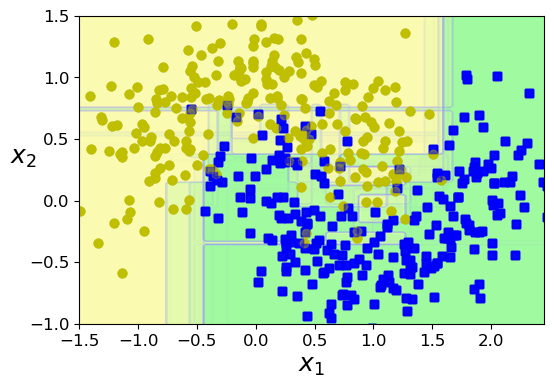

In [24]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X_train[indices_with_replacement], y_train[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.45, -1, 1.5],
                          alpha=0.2, contour=False)

plt.show()

Pixel importance with MNIST

In [25]:
from sklearn.datasets import fetch_openml 

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [26]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=4)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(n_jobs=4, random_state=42)

In [27]:
def plot_digit(data): 
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=mpl.cm.hot, 
              interpolation='nearest')
    plt.axis("off")

Saving figure mnist_feature_importance_plot


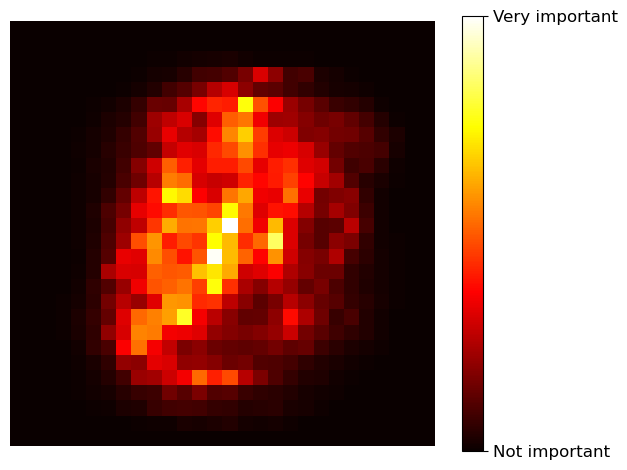

In [28]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig("mnist_feature_importance_plot")
plt.show()

# Boosting

Any ensemble method that combines several weak learners into a strong learner. Most popular are _AdaBoost_ (adaptive boosting) and _Gradient Boosting_.

## AdaBoost

Focuses on underfitted instances, focusing more on hard cases.

The algorithm trains a base classifier, makes predictions, the increases relative weight of misclassified instances, which it uses to train a second classifier, etc.

Each instance weight is set to 1/m. A predictor iw trained and its weighted error computed. The predictor's rate is updated, with more accuracy getting higher weight, random near zero, and mostly wrong negative values. The instance weights are updated, normalized and a new predictor is trained.

Predictions compute the predictions of all the predictors and weights and chooses the majority of weighted votes.

Scikit-Learn uses `SAMME` which is a multi-class version of AdaBoost.

If all predictors can estimate probabilities, the `SAMME.R` will perform better.

![](images/AdaBoost.png)

In [29]:
from sklearn.ensemble import AdaBoostClassifier 

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200, 
    algorithm='SAMME.R', learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

/nix/store/dkjj9vbdg3l305n13y1vgjckbkawhy3i-python3-3.12.7-env/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

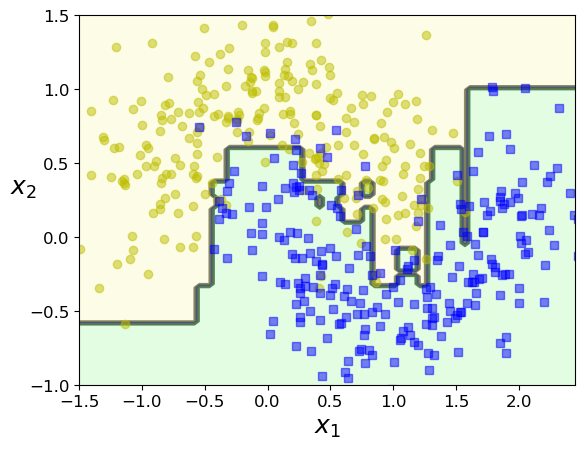

In [30]:
plot_decision_boundary(ada_clf, X, y);

In [31]:
from sklearn.ensemble import AdaBoostClassifier 

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200, 
    algorithm='SAMME', learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

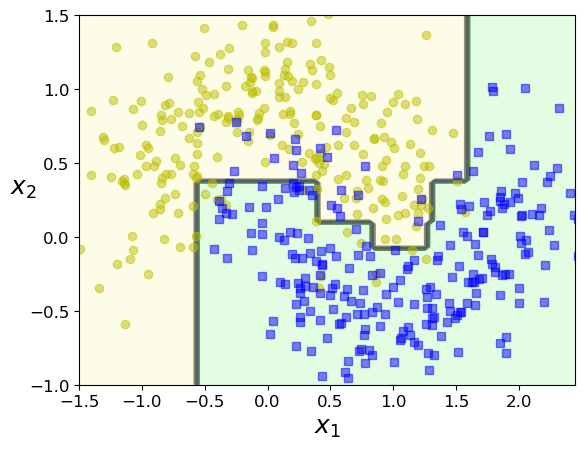

In [32]:
plot_decision_boundary(ada_clf, X, y);

Saving figure boosting_plot


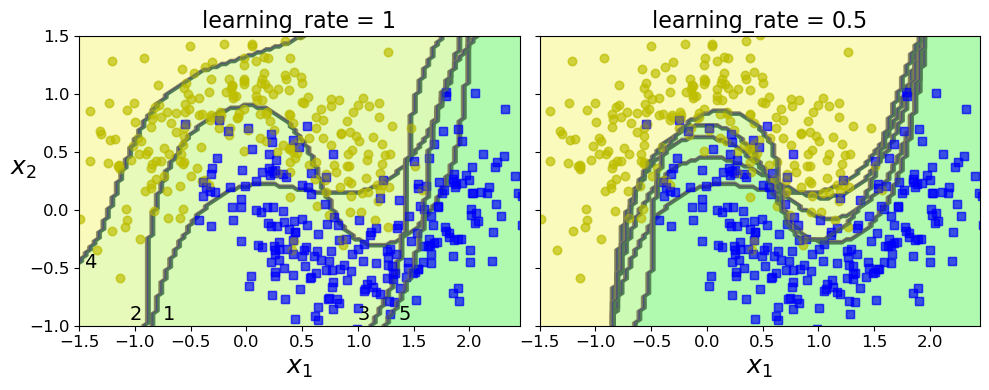

In [33]:
m = len(X_train)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum() # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r) # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha) # equation 7-3
        sample_weights /= sample_weights.sum() # normalization step

        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=14)
        plt.text(-1.05, -0.95, "2", fontsize=14)
        plt.text(1.0, -0.95, "3", fontsize=14)
        plt.text(-1.45, -0.5, "4", fontsize=14)
        plt.text(1.36,  -0.95, "5", fontsize=14)
    else:
        plt.ylabel("")

save_fig("boosting_plot")
plt.show()

# Gradient Boosting

Like AdaBoost, works sequentially, adding predictors, each one correcting its predecessor.

Fits new predictors to the residuals of previous predictors rather than updating weights at every iteration.

__Example of using gradient boosting manually.__

In [34]:
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

Train a second regressor on the residual errors of the first.

In [35]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X,y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

And a third

In [36]:
y3 = y - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X,y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [37]:
X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in 
            (tree_reg1, tree_reg2, tree_reg3))

In [38]:
y_pred

array([1.08692075])

In [39]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

Saving figure gradient_boosting_plot


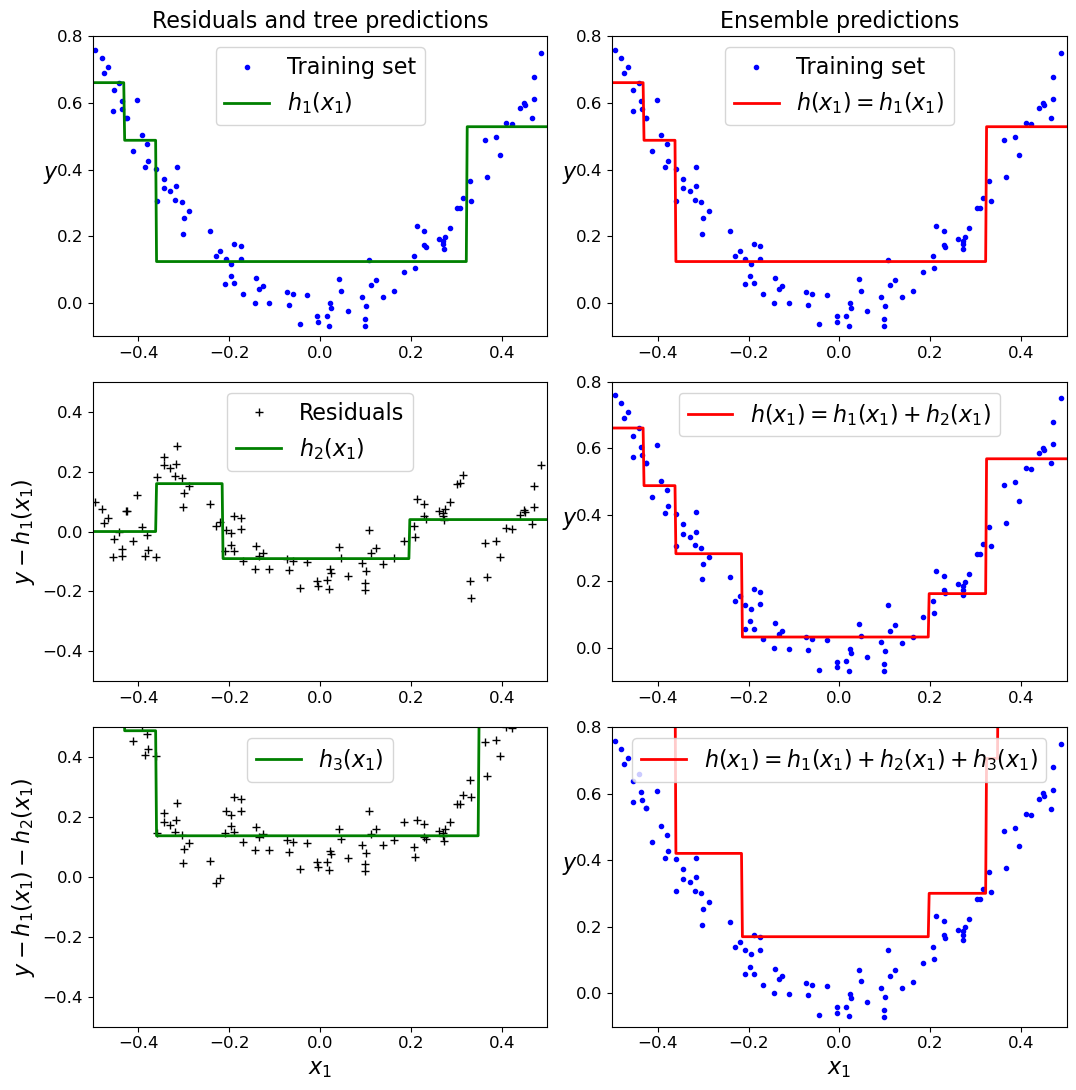

In [40]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

## Using `GradientBoostingRegressor`

In [41]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, 
                                 learning_rate=1.0)
gbrt.fit(X,y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

### Graphics Code

In [42]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

Saving figure gbrt_learning_rate_plot


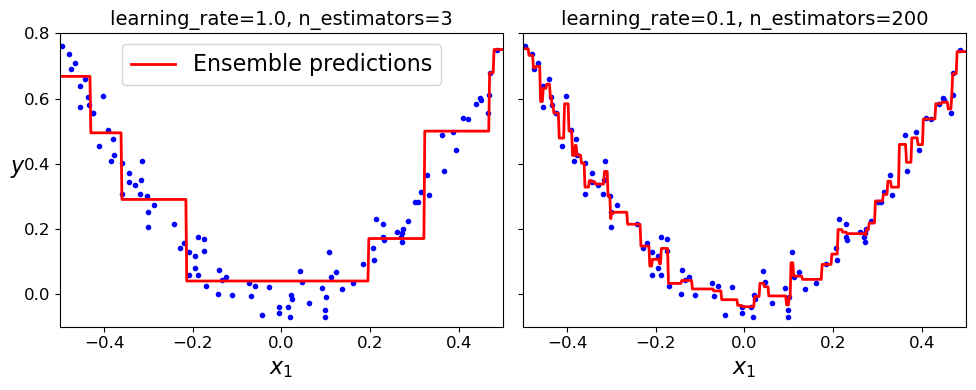

In [43]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

save_fig("gbrt_learning_rate_plot")
plt.show()

## Find the optimal number of trees

Early stopping

`staged_predict()` returns an iterator over the predictions made at each training stage.

A better method is presented after.

In [44]:
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

Xtrain, Xval, ytrain, yval = train_test_split(X,y, random_state=49)

In [45]:
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(Xtrain, ytrain)

GradientBoostingRegressor(max_depth=2, n_estimators=120)

In [46]:
errors = [mean_squared_error(yval, y_pred)
          for y_pred in gbrt.staged_predict(Xval)]
bst_n_estimators = np.argmin(errors) + 1

In [47]:
gbrt_best = GradientBoostingRegressor(max_depth=2, 
                                      n_estimators=bst_n_estimators)
gbrt_best.fit(Xtrain, ytrain)

GradientBoostingRegressor(max_depth=2, n_estimators=56)

In [48]:
min_error = np.min(errors)

Saving figure early_stopping_gbrt_plot


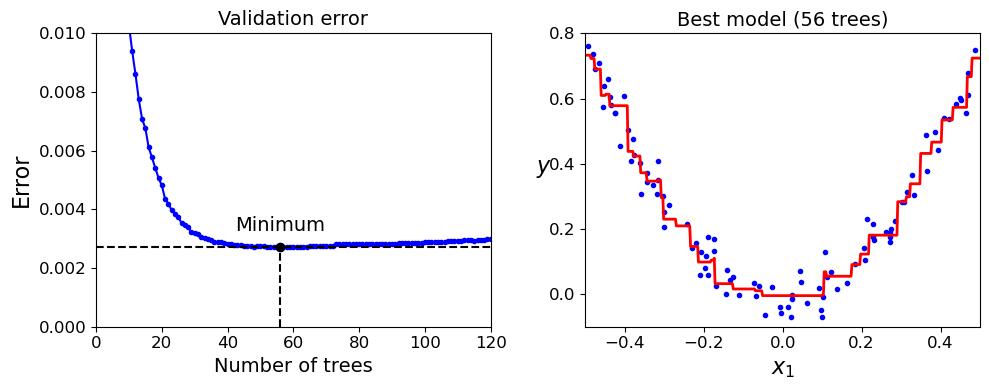

In [49]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(np.arange(1, len(errors) + 1), errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

save_fig("early_stopping_gbrt_plot")
plt.show()

use `warm_start`

This method stops training early instead of training a large number and looking back to determine the optimal number.

In [50]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, 
                                 random_state=42)
min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120): 
    gbrt.n_estimators = n_estimators
    gbrt.fit(Xtrain, ytrain)
    ypred = gbrt.predict(Xval)
    val_error = mean_squared_error(yval, ypred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else: 
        error_going_up += 1 
        if error_going_up == 5: 
            break

In [51]:
print(gbrt.n_estimators)

61


In [52]:
print(f"MSE: {min_val_error}")

MSE: 0.002712853325235463


`GradientBoostingRegressor` also supports a `subsample` hyperparameter to train on a percentage of instances selected randomly. This increases the bias, lowers the variance, and speeds 

## XGBoost

Extreme Gradient Boosting, optimized implementation of Gradient Boosting. It can automatically take care of early stopping.

In [54]:
import xgboost

In [55]:
xgd_reg = xgboost.XGBRegressor(random_state=42)
xgd_reg.fit(Xtrain, ytrain)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [57]:
ypred = xgd_reg.predict(Xval)
val_error = mean_squared_error(yval, ypred)
print(f"Validation error: {val_error}")

Validation error: 0.004644479346317078


In [58]:
xgd_reg.fit(Xtrain, ytrain, eval_set=[(Xval, yval)], 
            early_stopping_rounds=2)
ypred = xgd_reg.predict(Xval)
val_error = mean_squared_error(yval, ypred)
print(f"MSE Validation error: {val_error}")

[0]	validation_0-rmse:0.15232
[1]	validation_0-rmse:0.10690
[2]	validation_0-rmse:0.07868
[3]	validation_0-rmse:0.06385
[4]	validation_0-rmse:0.05656
[5]	validation_0-rmse:0.05486
[6]	validation_0-rmse:0.05394
[7]	validation_0-rmse:0.05556
MSE Validation error: 0.0029091166440151123


/nix/store/dkjj9vbdg3l305n13y1vgjckbkawhy3i-python3-3.12.7-env/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


In [59]:
xgd_reg = xgboost.XGBRegressor(early_stopping_rounds=2, random_state=42)

In [60]:
xgd_reg.fit(Xtrain, ytrain, eval_set=[(Xval, yval)])
ypred = xgd_reg.predict(Xval)
val_error = mean_squared_error(yval, ypred)
print(f"MSE Validation error: {val_error}")

[0]	validation_0-rmse:0.15232
[1]	validation_0-rmse:0.10690
[2]	validation_0-rmse:0.07868
[3]	validation_0-rmse:0.06385
[4]	validation_0-rmse:0.05656
[5]	validation_0-rmse:0.05486
[6]	validation_0-rmse:0.05394
[7]	validation_0-rmse:0.05556
MSE Validation error: 0.0029091166440151123


In [61]:
%timeit xgboost.XGBRegressor().fit(Xtrain, ytrain)

18.8 ms ± 3.75 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [62]:
%timeit GradientBoostingRegressor().fit(Xtrain, ytrain)

25.5 ms ± 645 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
